# Solving ODEs and PDEs numerically with Finite Difference Method in Python

## 1. Ordinary Differential Equation: SIR Model

A common workflow which leverages SciPy’s fast numerical ODE solving is
1. set up an ODE in SymPy
2. convert it to a numerical function using ```lambdify()```
3. solve the initial value problem by numerically integrating the ODE using SciPy ```solve_ivp```.

Here is an example from the field of Compartmental models in epidemiology where the nonlinear ordinary differential equations take this form:
\begin{align}
  \frac{dS}{dt} &= - \frac{\beta}{N} \, I S \,, \\
  \frac{dI}{dt} &= + \frac{\beta}{N} \, I S  - \gamma I\,, \\
  \frac{dR}{dt} &= + \gamma I\,, \\
\end{align}

where  $S$ is the stock of susceptible population, $I$ is the stock of infected,  $R$ is the stock of removed population (either by death or recovery), and $N$ is the sum of these three.

The *famous* **basic reproduction number* $r_0$ is defined as
$$ r_0 \equiv \frac{\beta}{\gamma} $$
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections) from a single infection in a population where all subjects are susceptible.

This idea can probably be more readily seen if we say that the typical time between contacts is  ${\displaystyle T_{c}=\beta ^{-1}}$, and the typical time until removal is  ${\displaystyle T_{r}=\gamma ^{-1}}$. From here it follows that, on average, the number of contacts by an infectious individual with others before the infectious has been removed is: ${\displaystyle T_{r}/T_{c}}$.



In [1]:
from sympy import symbols, lambdify, Function
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
# the parameter
t = symbols('t')
# Create symbols S, I, R
S = Function('S')(t)
I = Function('I')(t)
R = Function('R')(t)
# Now the free params
r0 = symbols('r0')

lhs = [
    S.diff(t) ,
    I.diff(t) ,
    R.diff(t) ,
]

print("Left Hand Side:")
display(lhs)

rhs = [
    - r0 * I * S ,
    + r0 * I * S - I ,
    + I
]
print("\nRight Hand Side:")
display(rhs)

odes = [
    lhs[i] - rhs[i]  for i in range(3)
]

print("\nODEs:")
odes

Left Hand Side:


[Derivative(S(t), t), Derivative(I(t), t), Derivative(R(t), t)]


Right Hand Side:


[-r0*I(t)*S(t), r0*I(t)*S(t) - I(t), I(t)]


ODEs:


[r0*I(t)*S(t) + Derivative(S(t), t),
 -r0*I(t)*S(t) + I(t) + Derivative(I(t), t),
 -I(t) + Derivative(R(t), t)]

In [2]:
# We need to accomodate scipy.integrate.solve_ivp will:
y = symbols('y:3')
b, c = symbols('b, c')
rhs = [
  - b * y[0] * y[1] ,
  + b * y[0] * y[1] - c * y[1] ,
  c * y[1]
]
display(rhs)

# Convert the SymPy symbolic expression for ydot into a form that
# SciPy can evaluate numerically, f
f = lambdify((t, y, b, c), rhs, "numpy")

param_vals = np.array([1.2, 0.5])        # arbitrary in this case, but bigger than 1
t_span = (0.0, 25.0 )
t_eval = np.linspace(t_span[0], t_span[1], 50) # evaluate integral from t = 0-10 for 50 points
initial_conds = [0.99, 0.01, 0.0]     # initial condition (initial values)

f(0.1, initial_conds, *list(param_vals) )

[-b*y0*y1, b*y0*y1 - c*y1, c*y1]

[-0.01188, 0.00688, 0.005]

In [3]:
# Call SciPy's ODE initial value problem solver solve_ivp by passing it
#   the function f,
#   the interval of integration,
#   the initial state, and
#   the arguments to pass to the function f

solution = scipy.integrate.solve_ivp(
    fun = f,
    t_span = t_span,
    y0 = initial_conds,
    t_eval=t_eval,
    args=param_vals
)

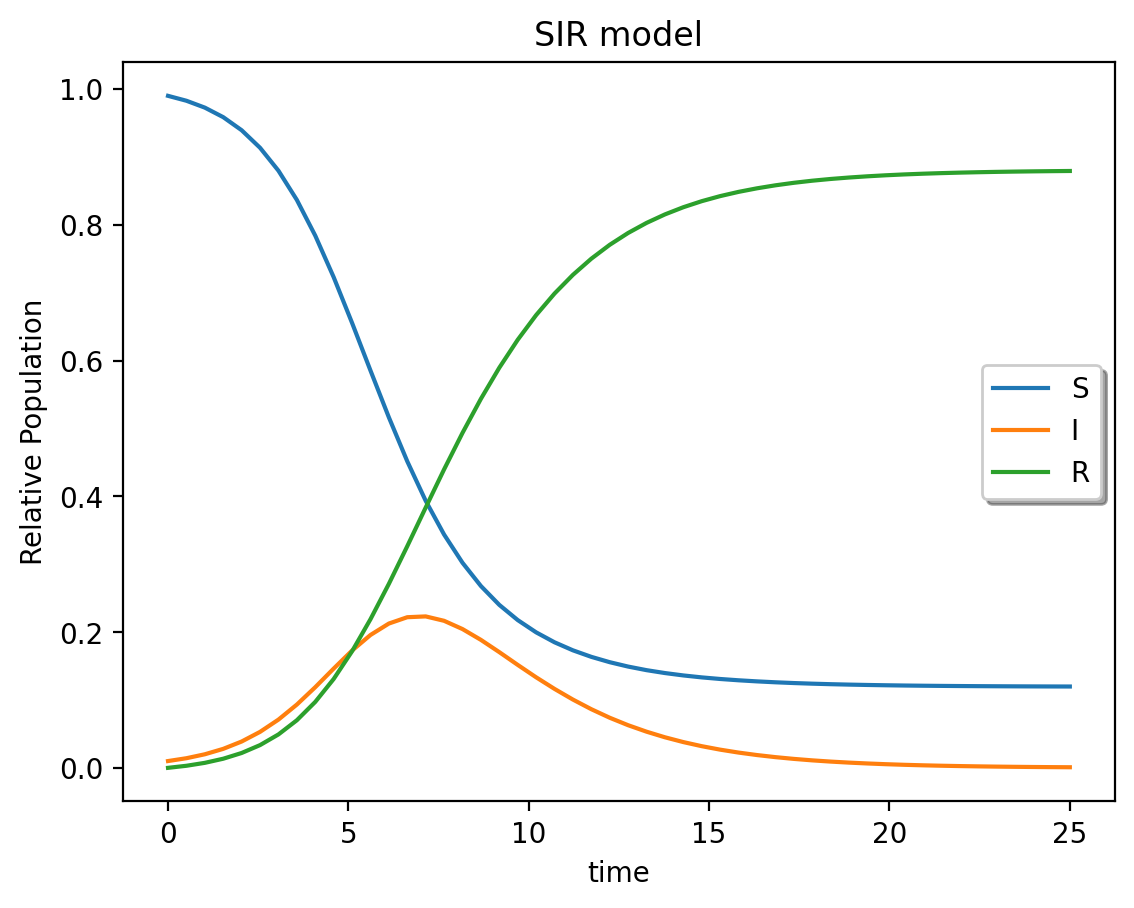

In [4]:
# Extract the y (concentration) values from SciPy solution result
y = solution.y
# Plot the result graphically using matplotlib
plt.figure(dpi=200)
plt.plot(t_eval, y.T)
# Add title, legend, and axis labels to the plot
plt.title(f'SIR model')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.xlabel('time')
plt.ylabel('Relative Population')
# Finally, display the annotated plot
plt.show()

#### Exercise #1: Try to solve the more general SEIRD ODE system

The SEIRD model generalise the SIR model by adding the *exposed* $E$ population, the *recovered* $R$ population and the *dead* $D$ population:

\begin{align}
  \frac{dS}{dt} &= - \beta \, I S \,, \\
  \frac{dE}{dt} &= + \beta \, I S - \kappa  E\,, \\
  \frac{dI}{dt} &= + \kappa  E  - (\gamma + \mu) I\,, \\
  \frac{dR}{dt} &= + \gamma I\,, \\
  \frac{dD}{dt} &= + \mu I\,, \\
\end{align}

-------
https://como-dtc-collaboration.github.io/como-models/articles/SEIRD.html

## Partial Differential Equations: Heat and Poisson

The most common PDEs emerging in the pysics domain are 2° Order PDEs, whose general form is
$$A \, \frac{\partial^2 u(x,t)}{\partial t^2} + B \, \frac{\partial^2 u(x,t)}{\partial t \partial x} + C \, \frac{\partial^2 u(x,t)}{\partial x^2} + D \, \frac{\partial u(x,t)}{\partial t} + E \, \frac{\partial u(x,t)}{\partial x} + F \, u = G(x,t) $$
usually, the LHS can be indicated as a 2° Order differential operator $\mathcal{L}_{A;B;C;D;E;F} [u](t)$ defined simply as
$$\mathcal{L}_{A;B;C;D;E;F} [u](t) \equiv A \, \frac{\partial^2 u(x,t)}{\partial t^2} + B \, \frac{\partial^2 u(x,t)}{\partial t \partial x} + C \, \frac{\partial^2 u(x,t)}{\partial x^2} + D \, \frac{\partial u(x,t)}{\partial t} + E \, \frac{\partial u(x,t)}{\partial x} + F \, u $$
We usually classify PDEs in three main classes, exploiting the similarities with the conical curves in planar geometry:

1. **Elliptic PDE**, when $B^2 - 4 A C < 0$; in this case, the PDE can be recasted as
$$\frac{\partial^2 u(x,t)}{\partial x^2} + \frac{\partial^2 u(x,t)}{\partial y^2} = 0$$
i.e. the *Laplace Equation* in 2D.

2. **Hyperbolic PDE**, when $B^2 - 4 A C > 0$; in this case, the PDE can be recasted as
$$\frac{1}{c^2} \frac{\partial^2 u(x,t)}{\partial t^2} - \frac{\partial^2 u(x,t)}{\partial x^2} = 0$$
i.e. the *Wave Equation* in 1D.

3. **Parabolic PDE**,  when $B^2 - 4 A C = 0$; in this case, the PDE can be recasted as
$$\frac{\partial u(x,t)}{\partial t} - D \frac{\partial^2 u(x,t)}{\partial x^2} = 0$$
i.e. the *Diffusion Equation* in 1D.




### 2.1. 1D heat equation

The goal is to solve numerically the 1D Heat equation:
$$\frac{\partial u(x,t)}{∂ t} = D \frac{\partial^2 u(x,t)}{∂ x^2}$$

The unknown in the diffusion equation is a function $u(x,t)$ of space and time. The physical significance of $u$  depends on what type of process that is described by the diffusion equation. For example, $u$
 is the concentration of a substance if the diffusion equation models transport of this substance by diffusion. Diffusion processes are of particular relevance at the microscopic level in biology, e.g., diffusive transport of certain ion types in a cell caused by molecular collisions. There is also diffusion of atoms in a solid, for instance, and diffusion of ink in a glass of water.

One very popular application of the diffusion equation is for heat transport in solid bodies. Then $u$
 is the temperature, and the equation predicts how the temperature evolves in space and time within the solid body. For such applications, the equations is known as the heat equation. We remark that the temperature in a fluid is influenced not only by diffusion, but also by the flow of the liquid. If present, the latter effect requires an extra term in the equation (known as an advection or convection term).

The term $g$
 is known as the source term and represents generation, or loss, of heat (by some mechanism) within the body. For diffusive transport, $g$
 models injection or extraction of the substance.

A partial differential equation is solved in some domain Ω
 in space and for a time interval $[0,T]$.

The solution of the equation is not unique unless we also prescribe initial and boundary conditions. The type and number of such conditions depend on the type of equation. For the diffusion equation, we need one initial condition, $u(x,0)$, stating what $u$ is when the process starts.

In addition, the diffusion equation needs one boundary condition at each point of the boundary $∂Ω$ of $Ω$ . This condition can either be that $u$ is known or that we know the normal derivative, $\nabla_{n} u = n \cdot ∇u$ (here $n$
 denotes an outward unit normal to $∂Ω$).

In [33]:
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.2.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.14.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/py

#### 2.1.1 Problem set up in 2D

Let us look at a specific application and how the diffusion equation with initial and boundary conditions then appears.
 We consider the evolution of temperature in a two-dimensional medium, where we have a certain excitation in a certain point at $t=0$.

There is no source term, i.e. $g=0$, and then the PDE system is
\begin{align}
\frac{\partial u(\vec{x},t)}{\partial t} &= D\nabla^2 u(\vec{x} , t) \,, \\
u(x,0) &= u_0 \delta (\vec{x} - \vec{x_0})
\end{align}
it is possible to rescale $(x,y) ↦ (\sqrt{D} \,x, \sqrt{D}\, y)$ and $u \mapsto u/u_0$ to the simpler problem

\begin{align}
\frac{\partial u(\vec{x},t)}{\partial t} &= \nabla^2 u(\vec{x} , t) \,, \\
u(\vec{x},0) &= \delta (\vec{x} - \vec{x_0}) \,, \\
u|_{\partial \Omega} &= 0 \,,
\end{align}

The discretised forward euler method, where $u_{i, j} (t) \equiv u(x_i, y_j, t)$ gives rise to

\begin{align}
\frac{\partial u_{i,j}(t)}{\partial t} &=  \frac{ u_{i+1, j} + u_{i, j+1} + u_{i-1, j} + u_{i, j-1} - 4 u_{i,j} }{4} \,, \\
u_{i,j}(0) &= \delta_{i, i_0} \delta_{j, j_0} \,, \\
u_{0,j} &= u_{i, 0} = 0 \,,
\end{align}

which, again, discretising in time, can be integrated as
$$ u_{i,j; t+1} = u_{i,j; t} +  \frac{ u_{i+1, j; t} + u_{i, j+1; t} + u_{i-1, j; t} + u_{i, j-1; t} - 4 u_{i,j; t} }{4} $$

------
http://hplgit.github.io/prog4comp/doc/pub/p4c-sphinx-Python/._pylight006.html

https://medium.com/@gerald.hoxha94/partial-differential-equations-in-python-23ccd160c082

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import tqdm 

T = 400
Nx = Ny = 100
u = np.zeros((T, Nx, Ny)) # initial condition
u[0, 50, 60] = +1 # source at T=0
u[0, 50, 40] = -1 # source at T=0

def impose_dirichlet_bc(u: np.array):
    u[0, :] = 0
    u[:, 0] = 0
    u[-1, :] = 0
    u[:, -1] = 0

def impose_neumann_bc(u: np.array):
    u[0, :] = u[t, 1, :]
    u[:, 0] = u[t, :, 1]
    u[-1, :] = u[t, -2, :]
    u[:, -1] = u[t, :, -2]

def impose_bc(u: np.array, use_dirichlet: bool = True):
    if use_dirichlet:
        impose_dirichlet_bc(u)
        return
    impose_neumann_bc(u)

alpha = 0.2  # stability requires alpha <= 0.25 ; alpha = \Delta t / \Delta x^2
for t in tqdm.tqdm( range(1, T) ):
    """
    un = np.pad(u[t-1, :, :], pad_width=((1,1)), mode='edge')
    laplacian = (
        un[2:, 1:-1] + un[:-2, 1:-1] +
        un[1:-1, 2:] + un[1:-1, :-2] -
        4 * un[1:-1, 1:-1]
    )
    u[t, :, :] = un[1:-1, 1:-1] + alpha * laplacian
    """
    un = u[t-1]
    laplacian = (
        np.roll(un, 1, axis=0) + np.roll(un, -1, axis=0) +
        np.roll(un, 1, axis=1) + np.roll(un, -1, axis=1) -
        4 * un
    )
    u[t] = un + alpha * laplacian
    # set bc
    impose_bc(u[t], True)

100%|██████████| 399/399 [00:00<00:00, 11470.29it/s]


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Example: suppose V_sol is already defined with shape [N_t, N_x, N_y]
# V_sol = np.random.rand(50, 100, 80)  # demo data

def plot_slice(t_idx):
    plt.figure(dpi=140)
    plt.imshow(
        u[t_idx, :, :], 
        origin='lower', aspect='auto', cmap='jet', 
        #vmin=u[0].min(), vmax=u[0].max()
    )
    plt.xlabel('x')
    plt.ylabel('y')   # careful: your array second axis is N_x, third is N_y
    plt.colorbar(label='Value')
    plt.title(f"Slice at t_idx = {t_idx}")
    plt.show()

# Create interactive slider
interact(plot_slice, t_idx=widgets.IntSlider(min=0, max=u.shape[0]-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='t_idx', max=399), Output()), _dom_classes=('widget-inter…

### 2.2. Jacobi Method for the Poisson PDE

We need to solve the Poisson PDE:
$$
\nabla^2 V = \rho
$$
We can discretise $V_{ij} = V(x_i, y_j)$, $\rho_{ij} = \rho(x_i, y_j)$

In [88]:
import numpy as np
import tqdm

Nx, Ny = 100, 100
V   = np.zeros((Nx, Ny))   # potential
rho = np.zeros((Nx, Ny)) # charge density

# Assign charges to plates
factor = 0.25
rho[45, 20:80] = +1.0 * factor  # left plate positively charged
rho[55, 20:80] = -1.0 * factor # right plate negatively charged

def impose_dirichlet_bc(u: np.array):
    u[0, :] = 0
    u[:, 0] = 0
    u[-1, :] = 0
    u[:, -1] = 0

def impose_neumann_bc(u: np.array):
    u[0, :] = u[t, 1, :]
    u[:, 0] = u[t, :, 1]
    u[-1, :] = u[t, -2, :]
    u[:, -1] = u[t, :, -2]

def impose_bc(u: np.array, use_dirichlet: bool = True):
    if use_dirichlet:
        impose_dirichlet_bc(u)
        return
    impose_neumann_bc(u)

# Jacobi iteration
n_iter = 5000
for _ in tqdm.tqdm(range(n_iter)):
    V_new = np.copy(V)
    V_new[1:-1, 1:-1] = 0.25 * (
        V[2:, 1:-1] + V[:-2, 1:-1] +
        V[1:-1, 2:] + V[1:-1, :-2] -
        rho[1:-1, 1:-1]
    )
    # enforce boundary conditions
    impose_bc(V_new)
    V = V_new


100%|██████████| 5000/5000 [00:00<00:00, 21307.37it/s]


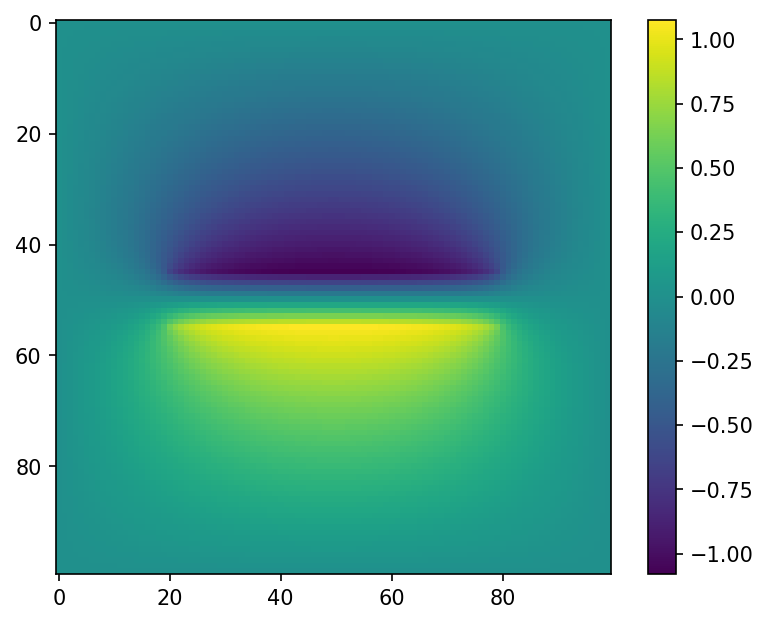

In [89]:
plt.figure(dpi=150)
plt.imshow(
    V_new
)
plt.colorbar()

#### Final Note: Jacobi Method as a Relaxation of a Diffusion Equation

Notice that, starting from the Jacobi method equation
\begin{align}
V_{ijk}^{n+1} = \frac{\Delta^2}{2}  \Big(  \; & \frac{V_{i+1,j,k}^n + V_{i-1,j,k}^n}{ \Delta x^2 }  \\
& + \frac{V_{i,j+1,k}^n + V_{i,j-1,k}^n}{ \Delta y^2 } \\
& + \frac{V_{i,j,k+1}^n + V_{i,j,k-1}^n}{ \Delta z^2 } + f_{ijk} \Big) 
\end{align}
we can add zero, written up as
\begin{align}
0 &= V^n_{ijk} - V^n_{ijk} \\
  &= V^n_{ijk} - \frac{\Delta^2}{2} \left( \frac{ 2 V_{ijk}^n}{ \Delta x^2 }  + \frac{ 2 V_{ijk}^n}{ \Delta y^2 }  + \frac{ 2 V_{ijk}^n}{ \Delta z^2 } \right)
\end{align}
and thus
\begin{align}
V_{ijk}^{n+1} - V^n_{ijk} = \frac{\Delta^2}{2}  \Big(  \; & \frac{V_{i+1,j,k}^n - 2 V_{ijk}^n + V_{i-1,j,k}^n}{ \Delta x^2 }  \\
& + \frac{V_{i,j+1,k}^n - 2 V_{ijk}^n + V_{i,j-1,k}^n}{ \Delta y^2 } \\
& + \frac{V_{i,j,k+1}^n - 2 V_{ijk}^n + V_{i,j,k-1}^n}{ \Delta z^2 } + f_{ijk} \Big) 
\end{align}

Which is the Forward Euler approximation of the Diffusion equation
\begin{align}
\frac{\partial V(t, \vec x)}{\partial t} = \Delta V(t, \vec x) + f(\vec x) \,,
\end{align}
with 
$$\Delta t = \frac{\Delta^2}{2} \,$$
where the initialisation of the field is, here, interpreted as the initial condition.

This means that the Jacobi method converges when the diffusive process ends. 

### 2.2 Non-trivial 3° Order PDE: how _really_ a capacitor charges in time?
You already knew the RC Circuit

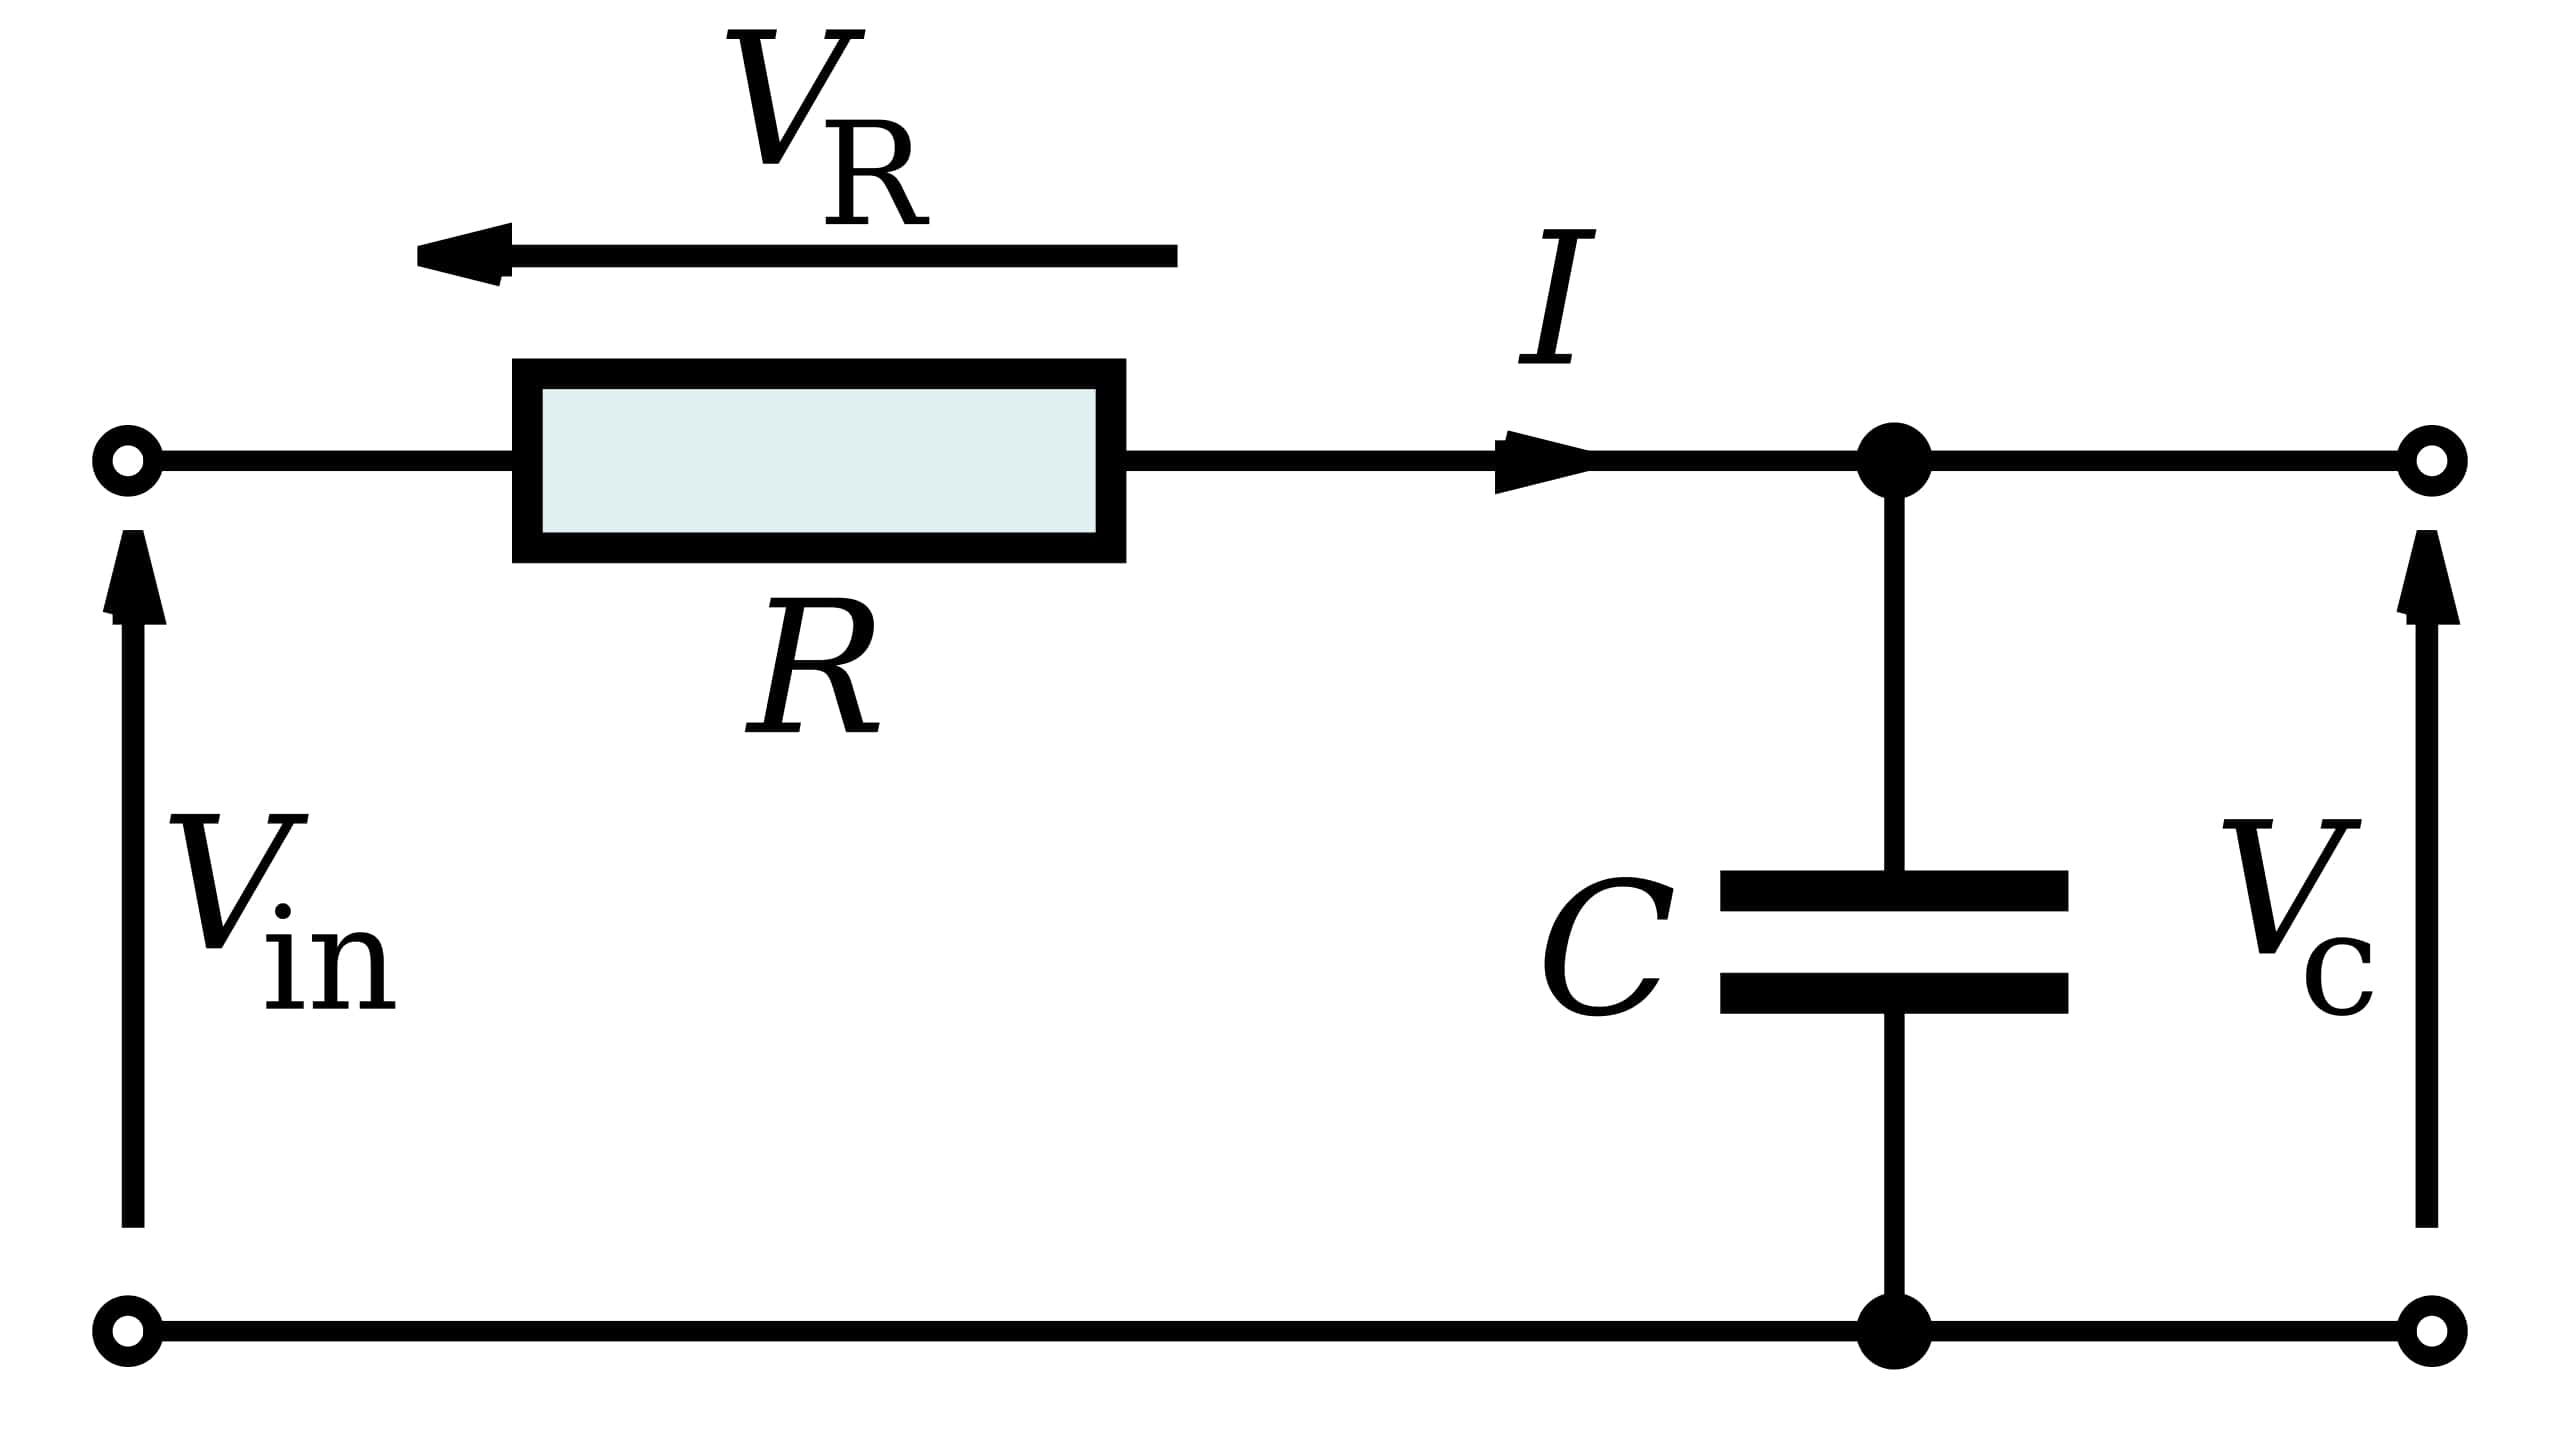

The ODE describing the circuit is 
\begin{align}
C \frac{\mathrm{d}V_C}{\mathrm{d}t} &= \frac{V_{in} - V_C}{R} \,, \\
V_{C} (0) &= 0 \,, 
\end{align}
which can be easily solved to obtain

$$
V_C (t) = V_{in} \left( 1 - \mathrm{e}^{- \frac{t}{RC}} \right) .
$$


But... how do potential evolve within the _resistor_? 

To model a _real_ capacitor, with a _conductive_ plate, we can describe it as follows: 
in the $[0, \ell]\subseteq \mathbb{R}$ region, we have a _conductive_ media, on the left, up to a point $0<a<\ell$, with conductivity $\sigma_0$.

We know that the charge $q(t,\mathbf{x})$ is _locally conserved_, so it must satisfy the _continuity equation_ 
$$ \partial_t q + \nabla \cdot \mathbf{J}(t,\mathbf{x}) = 0,$$
where $ \mathbf{J}$ is the electric current density, which, by Ohm Law is related to the electric field as
$$  \mathbf{J} = \sigma  \mathbf{E} = - \sigma \nabla V \,,$$
where the last relation holds if $ \mathbf{E}$ is _irrotational_. But, by Gauss law (first Maxwell equation)
$$ 
q = \epsilon \nabla \cdot  \mathbf{E} = -  \epsilon \nabla^2 V
$$

We thus get what is called the Maxwell equation in quasi-static approximation
$$
 \epsilon \nabla^2 \partial_t V + \nabla \cdot [ \sigma \nabla V] = 0 \,. 
$$

For a parallel plates geometry, we can reduce the problem to 1+1D
$$ 
\epsilon \partial_x^2 V + \partial_x \cdot [ \sigma \partial_x  V] = 0
$$




#### 2.2.1. Numerical setup in 1+1D:
This problem can be solved _in steps_:

\begin{align}
\partial_x^2 V = f \\
\partial_t f + \partial_x \sigma \partial_x V + \sigma \partial_x^2  V = 0
\end{align}

which can be approximated as ($V_{t_n, x_i} = V_{ni}$ and similar for $f$)
\begin{align}
f_{ni} &= \frac{V_{n(i+1)} - 2V_{ni} +V_{n(i-1)}}{\Delta x^2} \,, \\
f_{(n+1)i} &=  f_{ni} - \Delta t \left[ \sigma_i f_{ni} + \partial_x \sigma_i \partial_x V_{ni}  \right]  \,.
\end{align}

Where
\begin{align}
\partial_x \sigma_i &= \frac{\sigma_{i+1} - \sigma_{i-1}}{2 \Delta x} \,, \\
\partial_x V_{ni} &= \frac{V_{n(i+1)} - V_{n(i-1)}}{2 \Delta x} \,, \\
\end{align}


The Poisson equation 
$$ \frac{V_{n(i+1)} - 2V_{ni} +V_{n(i-1)}}{\Delta x^2} = f_{ni} $$
is solved iteratively by
$$ V_{ni}^{(a+1)} = \frac{1}{2} \left[ - \Delta x^2  f_{ni} + \left( V_{n(i+1)}^{(a)} +   V_{n(i-1)}^{(a)}   \right)   \right]$$


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def derx(
    V: np.array,
    deltaX: float , 
) -> np.array:
    if len(V.shape) == 1:
        Vn = np.pad(V, pad_width=((1,1)), mode='edge')
        dV = (Vn[2:] - Vn[:-2] )/(2*deltaX) #[N_t, N_x]
        return dV
    Vn = np.pad(V, pad_width=((0,0),(1,1)), mode='edge')
    dV = (Vn[:, 2:] - Vn[:, :-2] )/(2*deltaX) #[N_t, N_x]
    return dV

def derx2(
    V: np.array,
    deltaX: float 
) -> np.array:
    if len(V.shape) == 1:
        Vn = np.pad(V, pad_width=((1,1)), mode='edge')
        dV = (Vn[2:] - 2*Vn[1:-1] + Vn[:-2,] )/(2*deltaX) #[N_t, N_x]
    Vn  = np.pad(V, pad_width=((0,0),(1,1)), mode='edge')
    ddV = ( Vn[:, 2:] - 2*Vn[:, 1:-1] + Vn[:, :-2,] )/(deltaX**2)
    return ddV

In [11]:
# iperparams
ell = 1.0 # total height 
a   = 0.4 # cylinder height

N_x = 50
N_t = 500

t_max = 5.
t_range = np.arange(0., t_max, t_max/N_t)
x_range = np.arange(0., ell, ell/N_x)
V_sol = np.zeros([N_t, N_x], dtype=float)
V_sol[:, 0] = 1 # bc+ ic


sigma = np.zeros_like(x_range)
sigma[x_range < a] = 1.

deltaX = x_range[1]-x_range[0]
deltaT = t_range[1]-t_range[0]

In [8]:
der_sigma = derx(sigma, deltaX)

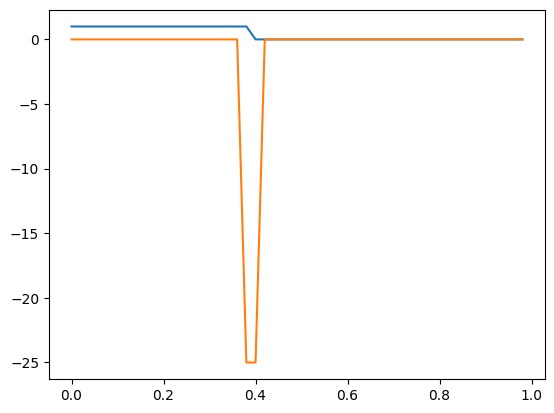

In [9]:
plt.plot(x_range, sigma)
plt.plot(x_range, der_sigma)

In [12]:
def solve_poisson(f: np.array, V0: np.array,  deltaX: float, N_iter: int=100):
    solV = V0
    for _ in range(N_iter):
        Vn = np.pad(solV, pad_width=((1,1)), mode='edge')
        solV = 0.5 * (
            - deltaX**2 * f + (Vn[2:] + Vn[:-2])
        )
        # enforce bc
        solV[ 0] = V0[0]
        solV[-1] = V0[-1]
    return solV

In [13]:
import tqdm
f = derx2(V_sol, deltaX)
for t_step in tqdm.tqdm( range(1, N_t) ):
    # 1. update V
    f[t_step, :] = f[t_step-1, :] - deltaT * (
        sigma[:]*f[t_step-1, :] + der_sigma[:] * derx(V_sol[t_step-1, :], deltaX)
    )
    # 2. update V
    V_sol[t_step, :] = solve_poisson(f=f[t_step, :], V0 = V_sol[t_step-1, :], deltaX=deltaX, N_iter = 100)
    # 3. Enforce BC.
    V_sol[:,  0] = 1.
    V_sol[:, -1] = 0.

100%|██████████| 499/499 [00:00<00:00, 637.32it/s]


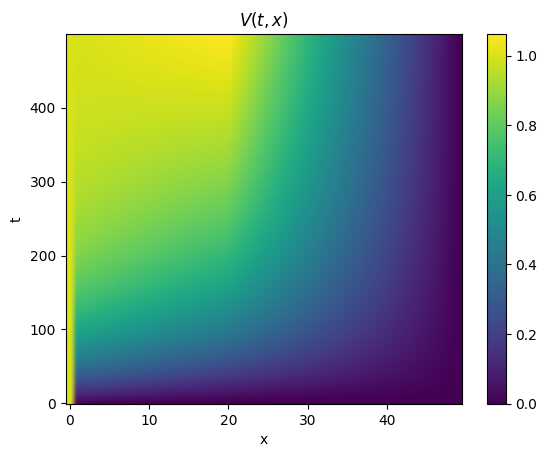

In [16]:
plt.imshow(V_sol, origin='lower', aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title("$V(t,x)$")
plt.colorbar()

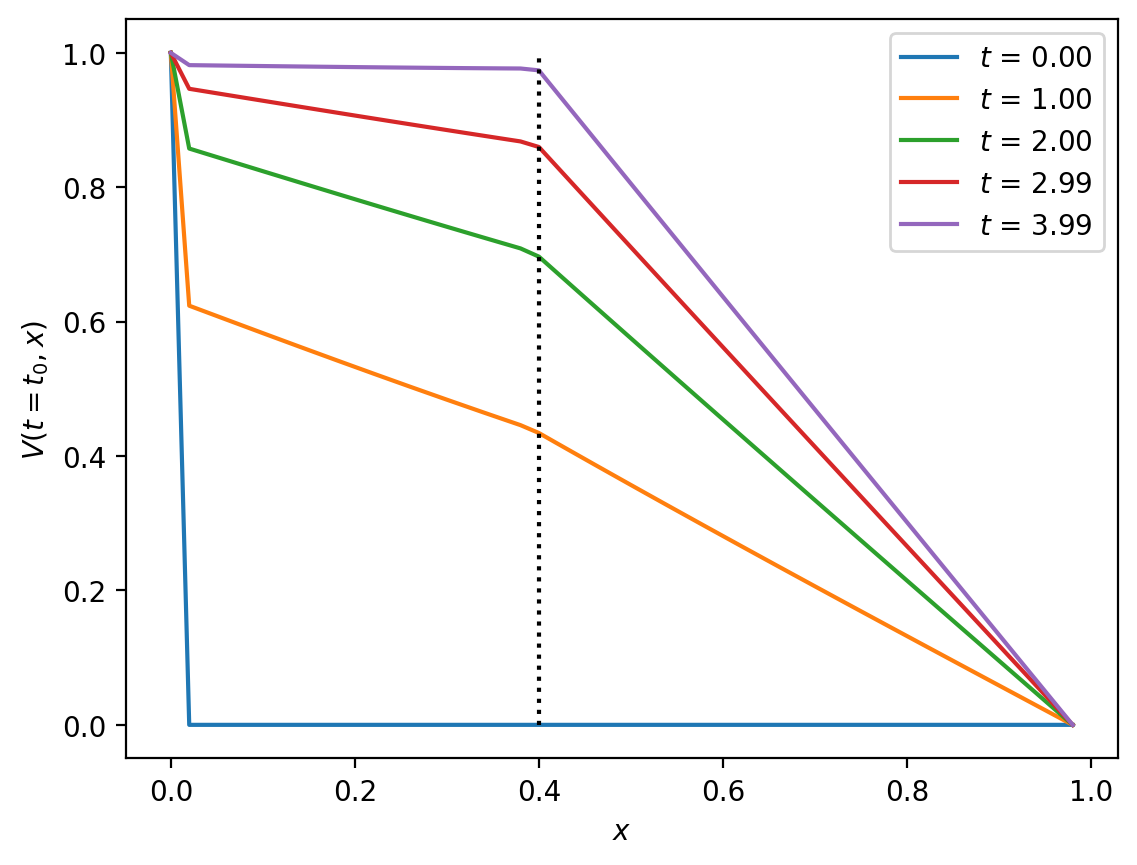

In [20]:
plt.figure(dpi=200)
N_plots = 5
for t_step in range(N_plots):
    t_label = t_step*N_t//N_plots
    plt.plot(
        x_range, 
        V_sol[t_label, :], label=f"$t$ = {(t_label/N_t* t_range[-1]):.2f}")
plt.legend()
plt.vlines(x=a, ymin=0, ymax=1, color='black', label='a', linestyles='dotted')
plt.xlabel('$x$')
plt.ylabel('$V(t=t_0, x)$')
#plt.ylim(0., 2.)
plt.show()